In [1]:
!pip install pyproj
!pip install geopandas
!pip install vincent

     |████████████████████████████████| 6.5MB 8.7MB/s 
     |████████████████████████████████| 972kB 7.1MB/s 
     |████████████████████████████████| 14.8MB 303kB/s 
  Created wheel for vincent: filename=vincent-0.4.4-cp36-none-any.whl size=35171 sha256=e902505e411b65ff1c12ecba594cd1078e1f2a292d197d7544b9d47fc585067c
  Stored in directory: /root/.cache/pip/wheels/4c/0d/8a/65f34c765c6094a71cce3e42a49a26533eef61695e9b505f03
Successfully built vincent


In [2]:
import pathlib
import random
from functools import reduce
from collections import defaultdict
import warnings
warnings.filterwarnings(action='ignore')
from functools import partial
from shapely import ops
import pyproj
import json, math
import matplotlib.pyplot as plt
from folium import plugins
import re
from matplotlib import font_manager, rc, rcParams
# def set_korea_font():
#     font_name = font_manager.FontProperties(fname="/System/Library/Fonts/Supplemental/AppleGothic.ttf").get_name()
#     rc('font', family=font_name)
#     rcParams.update({'font.size': 11})
#     rcParams['axes.unicode_minus'] = False  
# set_korea_font()
from shapely.geometry import Point as shapely_Point
from geopy.distance import great_circle as distance
from geopy.point import Point as Point
from math import sin, cos, atan2, sqrt, degrees, radians, pi
from IPython.display import display
import branca
from branca.colormap import linear

from geopy.distance import geodesic
import folium
from folium import plugins
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
import os
import datetime

#reproject import 필요

def reproject(geom, from_proj=None, to_proj=None):
    tfm = partial(pyproj.transform, pyproj.Proj(init=from_proj), pyproj.Proj(init=to_proj))
    return ops.transform(tfm, geom)

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import time
from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [3]:
df1 = pd.read_csv('feature50.csv')
df1

lon  ...  cross_road_nearby_count25
0     127.061509  ...                        3.0
1     127.061865  ...                        3.0
2     127.060957  ...                        3.0
3     127.068349  ...                        0.0
4     127.073558  ...                        0.0
...          ...  ...                        ...
3907  127.031869  ...                        0.0
3908  127.031906  ...                        0.0
3909  127.060430  ...                        0.0
3910  127.060416  ...                        0.0
3911  127.059933  ...                        0.0

[3912 rows x 26 columns]

In [4]:
learn_cols = ["lon",
              "lat",
              "overspeed_cam_count100",
              "floating_pop_count50",
              "shortest_bump_dist",
              "parking_count12.5",
              "parking_count25",
              "car_count1000", 
              "child_count1000",
              "elem_kinder_count400",
              "numberSchoolZone_count400",
              "num_cram_school_count400",
              "shortest_cross_dist",
              "shortest_traffic_signal_dist",
              "shortest_sidewalk_dist",
              "barrier_nearby_count12.5",
              "barrier_nearby_count25",
              "chaos1_nearby_count12.5",
              "chaos1_nearby_count25",
              "width_nearby_count12.5",
              "width_nearby_count25",
              "cross_road_nearby_count12.5",
              "cross_road_nearby_count25"]

cols = ["floating_pop_count50",
        "parking_count25",
        "car_count1000", 
        "child_count1000",
        "elem_kinder_count400",
        "numberSchoolZone_count400",
        "chaos1_nearby_count25",
        "cross_road_nearby_count25",
        "num_cram_school_count400",
        "shortest_cross_dist"]

In [5]:
#df1 feature 조절
#groupby로 count 하고
#등간이라고 생각되는 만큼 조절
df1.elem_kinder_count400.loc[df1.elem_kinder_count400 == 0] = 0
df1.elem_kinder_count400.loc[(df1.elem_kinder_count400 > 0)&(df1.elem_kinder_count400 <= 10)] = 1
df1.elem_kinder_count400.loc[(df1.elem_kinder_count400 > 10)] = 2

df1.numberSchoolZone_count400.loc[(df1.numberSchoolZone_count400 ==0 )] = 0
df1.numberSchoolZone_count400.loc[(df1.numberSchoolZone_count400 > 0)&(df1.numberSchoolZone_count400 <= 2)] = 1
df1.numberSchoolZone_count400.loc[(df1.numberSchoolZone_count400 > 2)] = 2

df1.num_cram_school_count400.loc[(df1.num_cram_school_count400 ==0 )] = 0
df1.num_cram_school_count400.loc[(df1.num_cram_school_count400 > 0)&(df1.num_cram_school_count400 <= 31)] = 1
df1.num_cram_school_count400.loc[(df1.num_cram_school_count400 > 31)] = 2

In [6]:
X = df1.loc[:,cols]
Y = df1["accident_count12.5"]

#X는 train test 값 둘다 알고 있고
#숨겨야 할것은 Y_test값 뿐
#고로 X에 대한 클러스터링은 train test 둘다 사용


#test_size 아주 robust함

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=1)

eps, min_samples =  0.578947 / 2
Estimated number of clusters: 416
Estimated number of noise points: 532


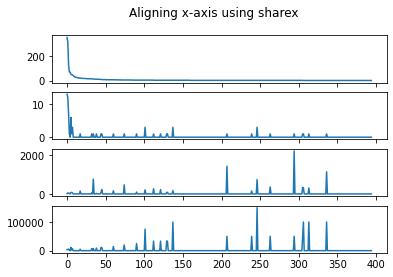

In [7]:
df2 = df1.loc[:,cols]

#dbscan
#https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html
#https://scikit-learn.org/stable/modules/clustering.html
#https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html
df2_sc = StandardScaler().fit_transform(df2)

#feature 조정된 값으로
#0.578947	2

db = DBSCAN(eps=0.578947, min_samples=2).fit(df2_sc)
labels_s = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_s)) - (1 if -1 in labels_s else 0)
n_noise_ = list(labels_s).count(-1)

print('eps, min_samples = ',0.578947,'/', 2)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


#label 별 지표
#근데 사실 hyperparameter 정하려고 y data 보는거 data leakage임! 보지 말자!
#엥간하면 그냥 silhuette 큰값 쓰는게 좋을듯
#사고 많이나는 클러스터 적게 나는 클러스터 할거 없이 그냥 cctv랑 corr 줄여주려고 stratification 한거니까
#group 좀 작게 해주면 좋고, noise set 줄여주면 좋고

#noise set이 평균 사고율
#grouped 된게 사고율 적은구간 큰구간 나뉘면 좋을듯

#train만
group_by_label = pd.concat([df1.loc[X_train.index],pd.DataFrame(labels_s).loc[X_train.index]],axis=1).groupby(0)
df6_s = pd.DataFrame()
df6_s['rows_count'] = group_by_label.apply(lambda x: x.floating_pop_count50.count())
df6_s['accident_count12.5'] = group_by_label.apply(lambda x: x['accident_count12.5'].sum())
df6_s['overspeed_cam_count100'] = group_by_label.apply(lambda x: x.overspeed_cam_count100.sum())
df6_s['accident_over_floating'] = group_by_label.apply(lambda x: x['accident_count12.5'].sum()*100000//x.floating_pop_count50.sum())
df6_s['accident_over_rows'] = group_by_label.apply(lambda x: x['accident_count12.5'].sum()*100000//x.floating_pop_count50.count())

df6_s = df6_s.sort_values('rows_count',ascending=False)
df6_s

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, sharex=True)
fig.suptitle('Aligning x-axis using sharex')

ax1.plot(range(len(df6_s)),df6_s.rows_count)
ax2.plot(range(len(df6_s)),df6_s['accident_count12.5'])
ax3.plot(range(len(df6_s)),df6_s.accident_over_floating)
ax4.plot(range(len(df6_s)),df6_s.accident_over_rows)

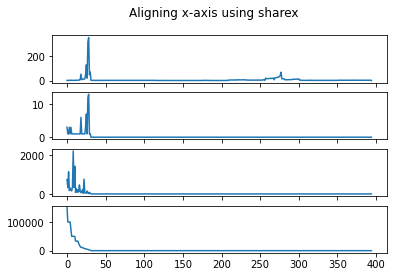

In [8]:
df6_ss = df6_s.sort_values('accident_over_rows',ascending=False)
df6_ss

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, sharex=True)
fig.suptitle('Aligning x-axis using sharex')

ax1.plot(range(len(df6_ss)),df6_ss.rows_count)
ax2.plot(range(len(df6_ss)),df6_ss['accident_count12.5'])
ax3.plot(range(len(df6_ss)),df6_ss.accident_over_floating)
ax4.plot(range(len(df6_ss)),df6_ss.accident_over_rows)

In [9]:
#distance 기준 대체 삽입

In [10]:
#모든 클러스터 각자 돌리는데 -1, 사고 다발, 무사고 만 세 군집으로 2nd cluster 해서 rf 해도 될듯

In [11]:
#outlier road의 사고통계량은 상대적으로 낮은 수치임을 예상할 수 있음
#그냥 마땅한 기준이 없어서 쓴값임
outlier_roads = df1.loc[labels_s == -1,learn_cols]
outlier_roads

#1st 2nd cluster class 둘다 있는 df 만들어 놓자
#learn_cols만 불러와야함

criterion = df6_s.loc[df6_s.index == -1].accident_over_rows.values[0]

df1_l1 = pd.concat([df1,pd.DataFrame(labels_s)],axis=1).loc[:,learn_cols+[0]]

high_acci_clusters = df1_l1.loc[pd.DataFrame(labels_s,columns=['first_clust']).first_clust.apply(lambda x: x in df6_s.loc[df6_s.accident_over_rows > criterion].index),learn_cols+[0]]
high_acci_clusters['second_class'] = np.ones([len(high_acci_clusters)])
low_acci_clusters = df1_l1.loc[pd.DataFrame(labels_s,columns=['first_clust']).first_clust.apply(lambda x: x in df6_s.loc[df6_s.accident_over_rows < criterion].index),learn_cols+[0]]
low_acci_clusters['second_class'] = np.zeros([len(low_acci_clusters)])

df1_l2 = pd.concat((high_acci_clusters,low_acci_clusters))

#test set의 index 들이 남음
# set(df1.index) - set(outlier_roads.index) - set(df1_l2.index)

In [12]:
#dbscan은 근데 연속적 점간 유사도여서 silhuette 쓰기 안좋을걸...
#그룹간, 그룹속 유클리디안 거리가 의미가 없어짐
#바로 인접하거나 끊어진 지점이 없는거 위주라서

#결과적으로 구별이 된다는건 클러스터가 유의미 하다는거지
#랜덤하게 끼워 맞춰졌으면 random noise가 나와야지
#high low로 구분돼서 나오지는 않지

In [13]:
df1_l2.groupby('second_class').count()

lon   lat  ...  cross_road_nearby_count25     0
second_class              ...                                 
0.0           2368  2368  ...                       2368  2368
1.0            966   966  ...                        966   966

[2 rows x 24 columns]

In [14]:
#예외처리

#cluster 중앙값 구하는 
def centre(cluster_id):
  currentMinimum = 99999
  datas = df1.loc[labels_s == cluster_id,cols]
  datas_s = StandardScaler().fit_transform(datas)

  for point_idx in range(len(datas_s)):
      distance_sum = 0
      for second_point_idx in range(len(datas_s)):
          if point_idx == second_point_idx : continue
          distance_sum += np.linalg.norm(datas_s[point_idx] - datas_s[second_point_idx])
      # print('>>>>>', point_idx, distance_sum) 

      if distance_sum < currentMinimum :
          currentMinimum = distance_sum 
          centre_point = datas_s[point_idx]
  return centre_point

#클러스터 끼리 중앙값중 가장 짧은 클러스터 구하기
#근데 ㅋㅋㅋ cluster 전부다 test set 들어가면 매치 못함 ㅋㅋㅋ
def closest(cluster_id, ban_list):
  currentMinimum = 99999
  clusters = list(set(labels_s))
  centre_point = centre(cluster_id)

  distance = 0
  for second_point_idx in range(len(clusters)):
    if cluster_id == clusters[second_point_idx] or (clusters[second_point_idx] in ban_list): continue
    distance = np.linalg.norm(centre_point - centre(clusters[second_point_idx]))
    # print('>>>>>', second_point_idx, distance) 

    if distance < currentMinimum :
      currentMinimum = distance 
      closest_clust = clusters[second_point_idx]

  return closest_clust



dic_1st_to_2nd = dict(zip(df1_l2.index,df1_l2.loc[:,'second_class']))

dic_1st_to_2nd[-1] = -1

#dbscan 최근접 cluster로 보내주는 함수 만들어서 쓰는게 좋을듯
#다 0으로 몰아넣지 말고

print(list(set(labels_s) - set(dic_1st_to_2nd.keys())))
#test set에서 안나오는 1st clusster 값들 있음
#일일이 보는게 좋긴함
for i in list(set(labels_s) - set(dic_1st_to_2nd.keys())):
  ban_list = list(set(labels_s) - set(dic_1st_to_2nd.keys()))
  closest_clust = closest(i,ban_list)
  
  if closest_clust in dic_1st_to_2nd.keys():
    dic_1st_to_2nd[i] = dic_1st_to_2nd[closest_clust]
    # print(">>> {}'s closest_cluster is {}".format(i,closest_clust))


[257, 386, 261, 137, 10, 395, 12, 140, 396, 15, 397, 17, 146, 276, 406, 407, 26, 282, 414, 162, 292, 165, 166, 39, 40, 175, 48, 176, 180, 56, 189, 323, 324, 325, 70, 200, 201, 202, 203, 77, 79, 81, 84, 342, 218, 91, 219, 93, 94, 222, 223, 224, 355, 101, 108, 238, 369, 126]


In [15]:
#안전 시설물까지 넣어서 회귀 모형 train 하자

#train 에 label 붙이고
#learn col 붙여
X_train_l = pd.concat([df1,pd.DataFrame(labels_s)],axis=1).loc[X_train.index,learn_cols+[0]].sort_index()
X_test_l = pd.concat([df1,pd.DataFrame(labels_s)],axis=1).loc[X_test.index,learn_cols+[0]].sort_index()

#붙인거 1st class 에 따라 나눠

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

#원래 -1 0 1 2 3 다 돌아가야하는데 test set에 안뽑히는것도 나옴 <- 수작업으로 걸러줘야함
squared_error = 0
test_predict_set = []
X_test0_indexs = []

#min max 통일해서 들어가자
X_train_p = df1.loc[X_train.index,learn_cols].sort_index()
Y_train_p = df1.loc[X_train.index,["accident_count12.5"]].sort_index()
X_test_p = df1.loc[X_test.index,learn_cols].sort_index()
Y_test_p = df1.loc[X_test.index,["accident_count12.5"]].sort_index()

X_train_p = MinMaxScaler().fit_transform(X_train_p)
X_test_p = MinMaxScaler().fit_transform(X_test_p)
Y_train_p = MinMaxScaler().fit_transform(Y_train_p)
Y_test_p = MinMaxScaler().fit_transform(Y_test_p)

for i in [-1,0,1]:
  # 2nd clust == 0 인거 해보자
  X_train0 = X_train_p[X_train_l.loc[:,0].apply(lambda x: dic_1st_to_2nd[x]) == i]
  Y_train0 = Y_train_p[X_train_l.loc[:,0].apply(lambda x: dic_1st_to_2nd[x]) == i]

  X_test0 = X_test_p[X_test_l.loc[:,0].apply(lambda x: dic_1st_to_2nd[x]) == i]
  Y_test0 = Y_test_p[X_test_l.loc[:,0].apply(lambda x: dic_1st_to_2nd[x]) == i]

  X_test0_indexs.append(X_test_l.loc[X_test_l.loc[:,0].apply(lambda x: dic_1st_to_2nd[x]) == i].index)


  #train만으로 cv 돌려서 hyper param 조율
  rf = RandomForestRegressor(random_state=1)
  rf.fit(X_train0, Y_train0)
  # print(rf.predict(X_test0))
  print(i,'번째 score',rf.score(X_train0,Y_train0))
  squared_error += (metrics.mean_squared_error(Y_test0, rf.predict(X_test0)))*len(Y_test0)
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test0, rf.predict(X_test0))))
  print('누적 Squared Error:', (metrics.mean_squared_error(Y_test0, rf.predict(X_test0)))*len(Y_test0))
  print(squared_error, len(Y_test0))
  print(" ")
  test_predict_set.append([Y_test0,rf.predict(X_test0)])
print('Total Root Mean Squared Error:', np.sqrt(squared_error/len(Y_test)))

-1 번째 score 0.852698371040724
Root Mean Squared Error: 0.06207062315996328
누적 Squared Error: 0.6896444444444444
0.6896444444444444 179
 
0 번째 score 0.8688307226015406
Root Mean Squared Error: 0.05294005707451842
누적 Squared Error: 1.7012083333333332
2.3908527777777775 607
 
1 번째 score 0.855012519296079
Root Mean Squared Error: 0.0990575501404309
누적 Squared Error: 4.95526111111111
7.346113888888887 505
 
Total Root Mean Squared Error: 0.07543375161143548


In [16]:
#대차대조를 위한 no strata rf_p(plain)
X_train_p = df1.loc[X_train.index,learn_cols].sort_index()
Y_train_p = df1.loc[X_train.index,["accident_count12.5"]].sort_index()
X_test_p = df1.loc[X_test.index,learn_cols].sort_index()
Y_test_p = df1.loc[X_test.index,["accident_count12.5"]].sort_index()

#위 strata와 비교할 수 있게 rf_p.predict 구간별 분리
X_test_p_0 = MinMaxScaler().fit_transform(X_test_p.loc[X_test0_indexs[0]])
X_test_p_1 = MinMaxScaler().fit_transform(X_test_p.loc[X_test0_indexs[1]])
X_test_p_2 = MinMaxScaler().fit_transform(X_test_p.loc[X_test0_indexs[2]])



X_train_p = MinMaxScaler().fit_transform(X_train_p)
X_test_p = MinMaxScaler().fit_transform(X_test_p)
Y_train_p = MinMaxScaler().fit_transform(Y_train_p)
Y_test_p = MinMaxScaler().fit_transform(Y_test_p)



#train만으로 cv 돌려서 hyper param 조율
#bootstrap=True, max_depth=50,max_features='sqrt',min_samples_leaf=4, min_samples_split= 5, n_estimators=180, random_state=1
rf_p = RandomForestRegressor(random_state=1)
rf_p.fit(X_train_p, Y_train_p)
# print(rf_p.predict(X_test0))
print('score',rf_p.score(X_train_p,Y_train_p))

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test_p, rf_p.predict(X_test_p))))




score 0.8595794933416269
Root Mean Squared Error: 0.07975865134847838


In [17]:
#stratification 한게 더 잘나옴
#훨씬 안정적이니까 logistic link function 넣어서 극단값 강조해도 될듯

#선형회귀로 비교하면 훨씬 잘나올듯 hyper param 조율 안해도 되니까

In [18]:
concat_diff = pd.DataFrame((test_predict_set[0][0].reshape(len(test_predict_set[0][0])) - test_predict_set[0][1]),index=X_test0_indexs[0])
concat_diff = pd.concat((concat_diff,pd.DataFrame((test_predict_set[1][0].reshape(len(test_predict_set[1][0])) - test_predict_set[1][1]),index=X_test0_indexs[1])))
concat_diff = pd.concat((concat_diff,pd.DataFrame((test_predict_set[2][0].reshape(len(test_predict_set[2][0])) - test_predict_set[2][1]),index=X_test0_indexs[2])))
concat_diff = concat_diff.sort_index()

diff_0 = pd.DataFrame((test_predict_set[0][0].reshape(len(test_predict_set[0][0])) - test_predict_set[0][1]),index=X_test0_indexs[0])
diff_1 = pd.DataFrame((test_predict_set[1][0].reshape(len(test_predict_set[1][0])) - test_predict_set[1][1]),index=X_test0_indexs[1])
diff_2 = pd.DataFrame((test_predict_set[2][0].reshape(len(test_predict_set[2][0])) - test_predict_set[2][1]),index=X_test0_indexs[2])
sum(diff_2.sort_index()>0)

concat_prid = pd.DataFrame(test_predict_set[0][1],index=X_test0_indexs[0])
concat_prid = pd.concat((concat_prid,pd.DataFrame(test_predict_set[1][1],index=X_test0_indexs[1])))
concat_prid = pd.concat((concat_prid,pd.DataFrame(test_predict_set[2][1],index=X_test0_indexs[2])))
concat_prid = concat_prid.sort_index()
concat_prid


0
3     0.045
4     0.015
6     0.085
7     0.035
10    0.000
...     ...
3899  0.000
3903  0.000
3905  0.000
3907  0.110
3909  0.000

[1291 rows x 1 columns]

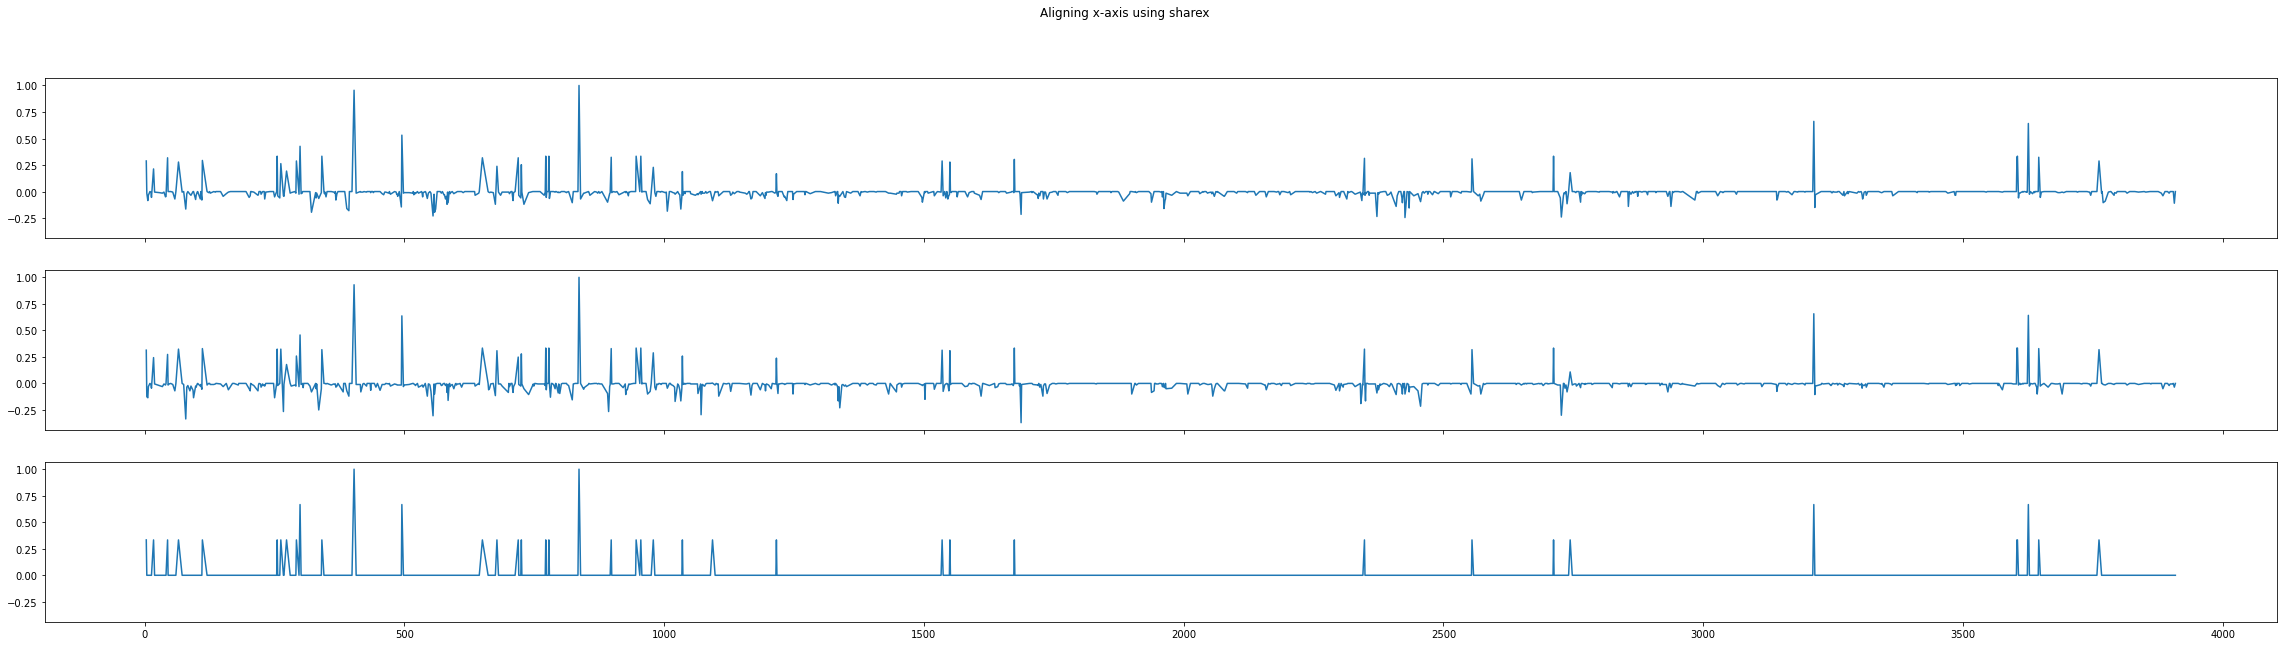

In [47]:
fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(40,10), sharex=True,sharey=True)
fig.suptitle('Aligning x-axis using sharex')


#y test 의 min max scaler가 다름 ㅋㅋㅋㅋㅋ

#안잡히는 사고들은 도로 구조적 원인이 아닌 사고들, 우천시 사고, 평균적 부주의
i = 1
Y_test0, predicted = test_predict_set[i][0],test_predict_set[i][1]

#이 몇개 빼먹었다고 생각하면됨
ax1.plot(concat_prid.index,(Y_test_p.reshape(len(Y_test_p)) - concat_prid.to_numpy().reshape(len(concat_prid))))

# red = noise set, green = safe set, blue = danger set
# ax1.plot(diff_0.index,diff_0.to_numpy().reshape(len(diff_0)),color='r')
# ax1.plot(diff_1.index,diff_1.to_numpy().reshape(len(diff_1)),color='g')
# ax1.plot(diff_2.index,diff_2.to_numpy().reshape(len(diff_2)),color='b')

ax2.plot(concat_prid.index,(Y_test_p.reshape(len(Y_test_p)) -  rf_p.predict(X_test_p)))
ax3.plot(concat_prid.index,Y_test_p.reshape(len(Y_test_p)))

<BarContainer object of 1291 artists>

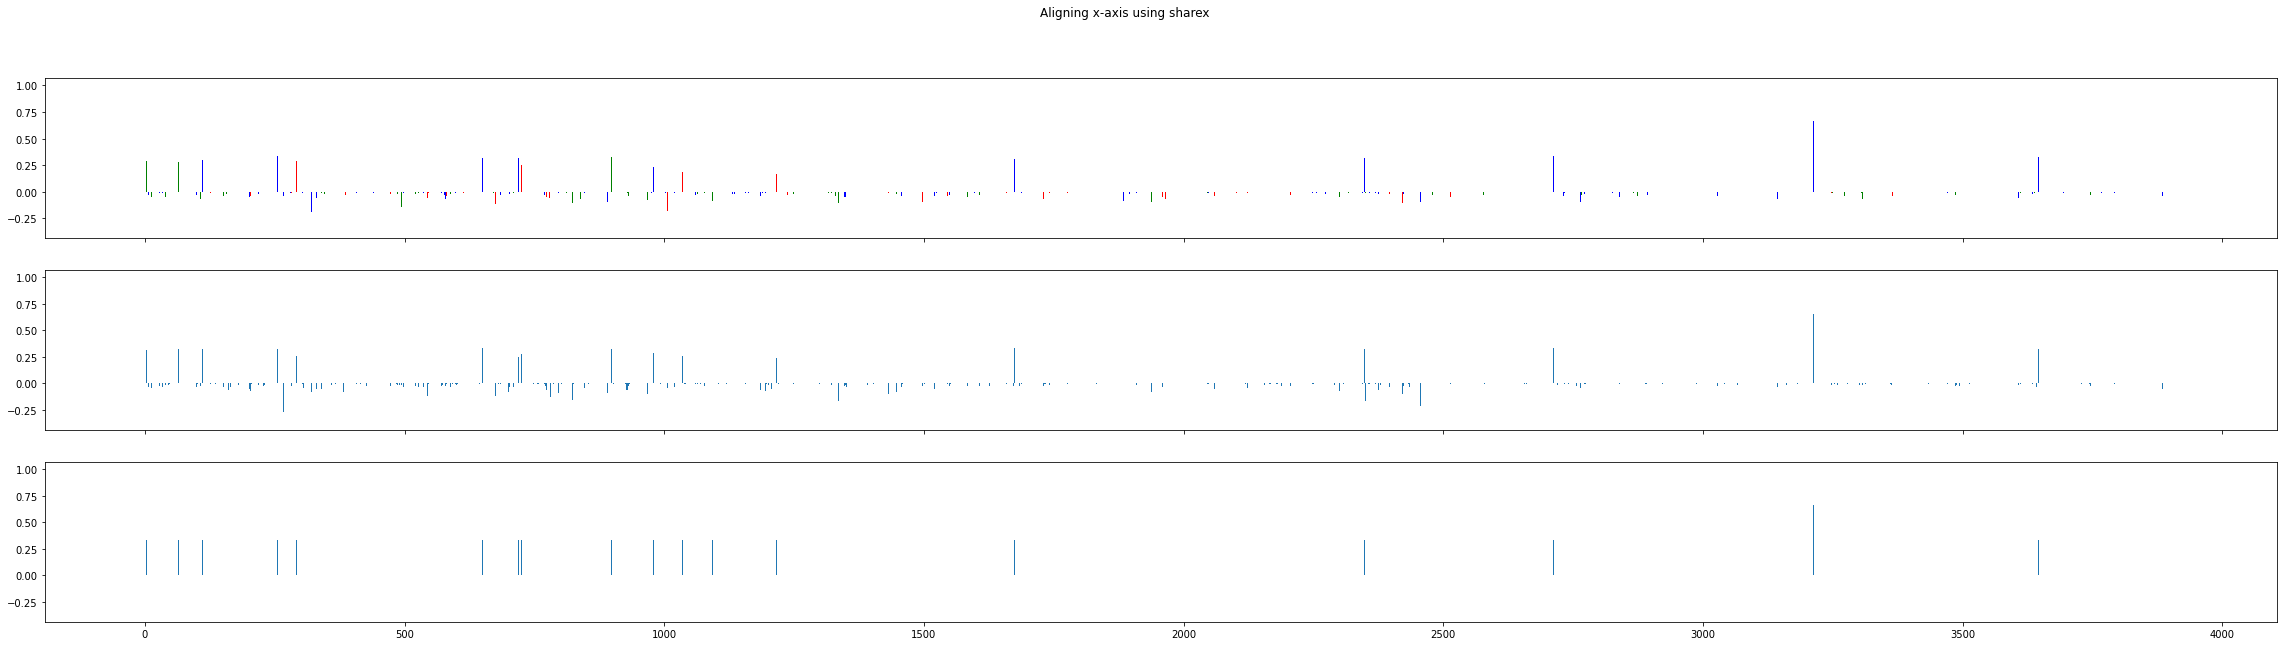

In [20]:
fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(40,10), sharex=True,sharey=True)
fig.suptitle('Aligning x-axis using sharex')


#y test 의 min max scaler가 다름 ㅋㅋㅋㅋㅋ

#안잡히는 사고들은 도로 구조적 원인이 아닌 사고들, 우천시 사고, 평균적 부주의
i = 1
Y_test0, predicted = test_predict_set[i][0],test_predict_set[i][1]

#이 몇개 빼먹었다고 생각하면됨

h1_0 = diff_0.to_numpy().reshape(len(diff_0))
h1_1 = diff_1.to_numpy().reshape(len(diff_1))
h1_2 = diff_2.to_numpy().reshape(len(diff_2))
h2 = (Y_test_p.reshape(len(Y_test_p)) -  rf_p.predict(X_test_p))
h3 = Y_test_p.reshape(len(Y_test_p))

# ax1.plot(concat_prid.index,(Y_test_p.reshape(len(Y_test_p)) - concat_prid.to_numpy().reshape(len(concat_prid))))
ax1.bar(diff_0.index,h1_0,color='r')
ax1.bar(diff_1.index,h1_1,color='g')
ax1.bar(diff_2.index,h1_2,color='b')

ax2.bar(concat_prid.index,h2)
ax3.bar(concat_prid.index,h3)

<BarContainer object of 1291 artists>

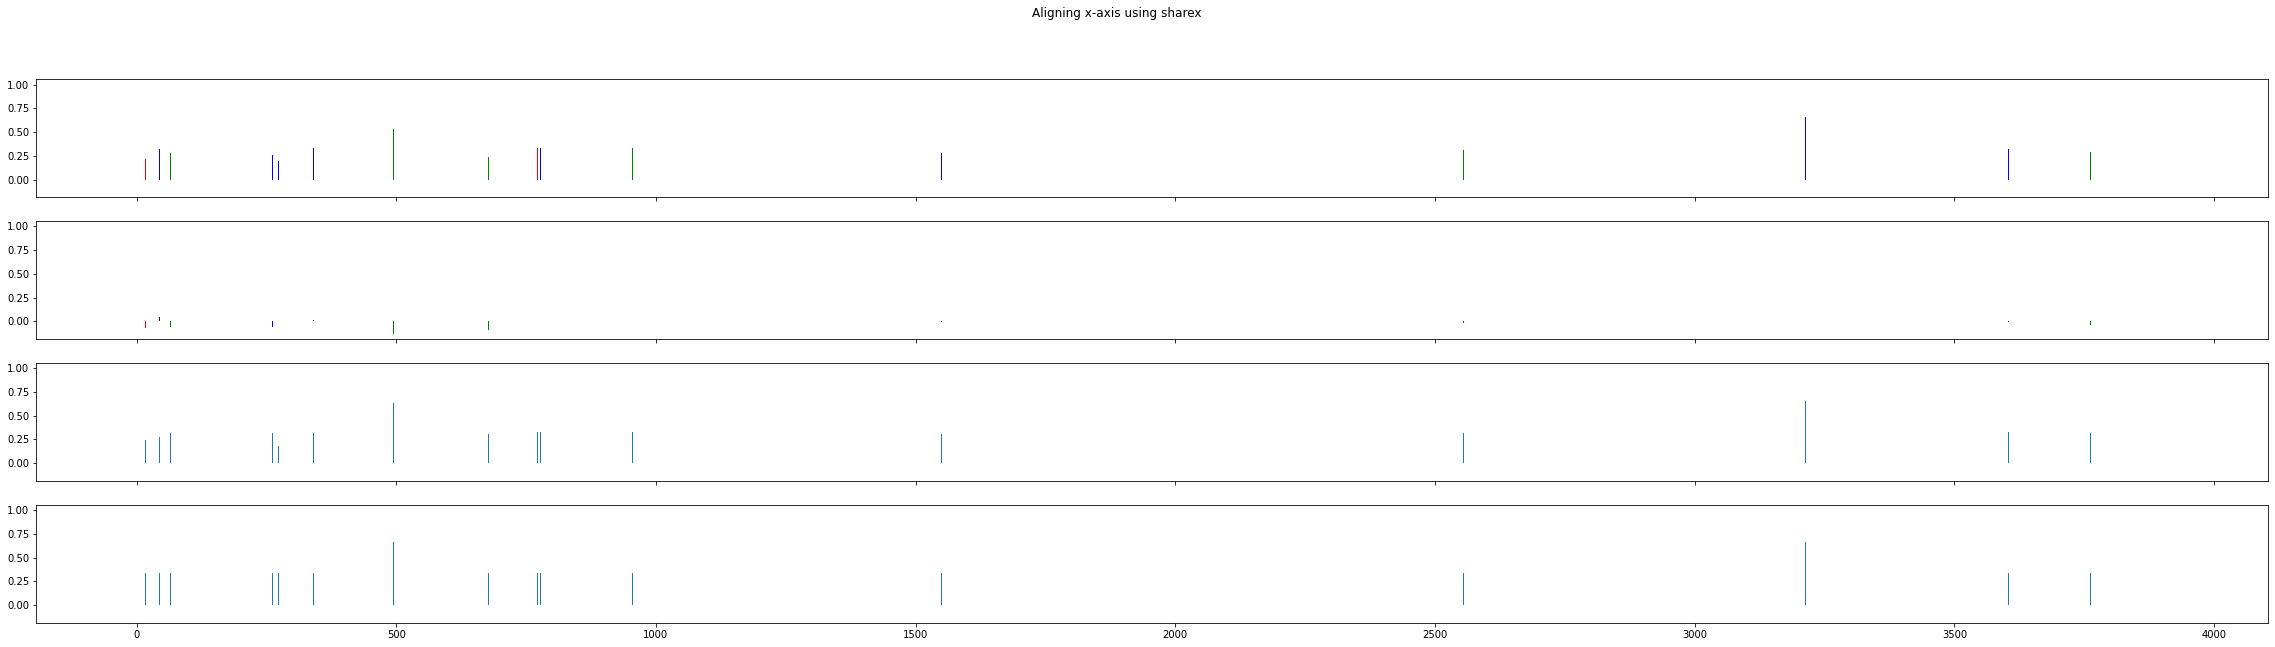

In [21]:
#사고들 얼마나 잡았는지
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,figsize=(40,10), sharex=True, sharey=True)
fig.suptitle('Aligning x-axis using sharex')


#y test 의 min max scaler가 다름 ㅋㅋㅋㅋㅋ(해결 완료)

#안잡히는 사고들은 도로 구조적 원인이 아닌 사고들, 우천시 사고, 평균적 부주의
i = 1
Y_test0, predicted = test_predict_set[i][0],test_predict_set[i][1]

#이 몇개 빼먹었다고 생각하면됨

h1_0 = diff_0.to_numpy().reshape(len(diff_0))
h1_1 = diff_1.to_numpy().reshape(len(diff_1))
h1_2 = diff_2.to_numpy().reshape(len(diff_2))

diff_p_0 = pd.DataFrame((test_predict_set[0][0].reshape(len(test_predict_set[0][0])) - rf_p.predict(X_test_p_0)),index=X_test0_indexs[0])
diff_p_1 = pd.DataFrame((test_predict_set[1][0].reshape(len(test_predict_set[1][0])) - rf_p.predict(X_test_p_1)),index=X_test0_indexs[1])
diff_p_2 = pd.DataFrame((test_predict_set[2][0].reshape(len(test_predict_set[2][0])) - rf_p.predict(X_test_p_2)),index=X_test0_indexs[2])


h2_0 = diff_p_0.to_numpy().reshape(len(diff_p_0))
h2_1 = diff_p_1.to_numpy().reshape(len(diff_p_1))
h2_2 = diff_p_2.to_numpy().reshape(len(diff_p_2))

h3 = (Y_test_p.reshape(len(Y_test_p)) -  rf_p.predict(X_test_p))
h4 = Y_test_p.reshape(len(Y_test_p))

#0빼고 보기(보수적인 기준) h1 - h2 했을때
h1_0[h1_0<=0] = 0
h1_1[h1_1<=0] = 0
h1_2[h1_2<=0] = 0

h2_0[h2_0<=0] = 0
h2_1[h2_1<=0] = 0
h2_2[h2_2<=0] = 0


#줄일수 있었던 사고들이 음수로 나타남
h2_0 = h1_0 - h2_0
h2_1 = h1_1 - h2_1
h2_2 = h1_2 - h2_2


h3[h3<=0] = 0
h4[h4<=0] = 0

ax1.bar(diff_0.index,h1_0,color='r')
ax1.bar(diff_1.index,h1_1,color='g')
ax1.bar(diff_2.index,h1_2,color='b')

ax2.bar(diff_0.index,h2_0,color='r')
ax2.bar(diff_1.index,h2_1,color='g')
ax2.bar(diff_2.index,h2_2,color='b')


ax3.bar(concat_prid.index,h3)
ax4.bar(concat_prid.index,h4)



In [22]:
#

In [23]:
#지도에 찍어보기
#지도 import

#20. cctv 불러오기, 잘못된 정보 수정
  #C == 어린이 보호
cctv_df = pd.read_csv('20.오산시_CCTV설치현황.csv')

cctv_df_t = cctv_df[cctv_df['설치위치_위도']>40]
cctv_df_o = cctv_df[cctv_df['설치위치_위도']<40]
cctv_df['geometry'] = list(zip(cctv_df_o.iloc[:,2],cctv_df_o.iloc[:,3]))+list(zip(cctv_df_t.iloc[:,3],cctv_df_t.iloc[:,2]))

#Link & Node
#오산시 상세도로망 1875개
#중복없음: sum(road_gdf.link_id.duplicated()) == 0
road_gdf = gpd.read_file('23.오산시_상세도로망_LV6.geojson')

road_to_geo = {}
for i in range(len(road_gdf)):
  road_to_geo[road_gdf.link_id[i]] = road_gdf.geometry[i]

road_to_lanes = {}
for i in range(len(road_gdf)):
  road_to_lanes[road_gdf.link_id[i]] = road_gdf.up_lanes[i]+road_gdf.dw_lanes[i]

road_to_laned = {}
for i in range(len(road_gdf)):
  road_to_laned[road_gdf.link_id[i]] = road_gdf.car_lane[i]

road_to_width = {}
for i in range(len(road_gdf)):
  road_to_width[road_gdf.link_id[i]] = road_gdf.width[i]

road_to_link_type = {}
for i in range(len(road_gdf)):
  road_to_link_type[road_gdf.link_id[i]] = road_gdf.link_type[i]


l1 = ['101', '102', '103', '104', '105', '106', '107', '108']
l2 = ['고속국도','도시고속국도','일반국도','특별광역시도','국가지원지방도','지방도','시군도','고속도로 연결램프']
road_rank_dict = dict(zip(l1,l2))

l1 = ['1','2','4','8','16','32','64','128','513','516','2049','2052','2056','2080','2112','32768','32772','33280','34816','36864',]
l2 = ['본선 분리','연결로(JC)','교차로 통로','연결로(IC)','SA 레이어',
      '복합교차로','로타리','회전교차로','P-turn/본선분리','P-turn/교차로통로',
      '진출입로/본선분리','진출입로/교차로통로','진출입로/연결로IC','진출입로/복합교차로',
      '진출입로/교차로','본선 비분리','본선비분리/교차로통로','본선비분리/P-turn','본선비분리/진출입로',
      '본선비분리/단지내 도로']
road_type_dict = dict(zip(l1,l2))

# #고속도로 제외
# road_gdf = road_gdf.loc[(road_gdf.road_rank.apply(lambda x:x in ['103','104','105','106','107']))]


#혼잡빈도강도 3032개
chaos1_df = pd.read_csv('25.평일_전일_오산시_혼잡빈도강도_Level6.csv')
chaos1_df['geometry'] = chaos1_df.iloc[:,0].apply(lambda x: road_to_geo[str(x)[:-2]] if str(x)[:-2] in road_to_geo.keys() else False)
chaos1_df.columns = ['link_id','rank','length','name','sido','sigungo','eub','time_range','work/weekend','chaos1','geometry']
#to gdf
chaos1_gdf = gpd.GeoDataFrame(chaos1_df, crs='EPSG:4326')

#19. 오산시 신호등
traffic_light_gdf = gpd.read_file('19.오산시_신호등.geojson')

traffic_light_gdf.head()

#BULD_SE_CD
#[08101, 08102, 08103, 08199, 08201, 08202, 08003, 08204, 08299]
school_list = ['08101', '08102', '08103', '08199', '08201', '08202', '08003', '08204', '08299']

building_gdf = gpd.read_file('27.오산시_도로명주소_건물.geojson')
building_gdf_school = building_gdf[building_gdf.BDTYP_CD.apply(lambda x : True if (x in school_list) else False)]



In [49]:

#지도 그리기
from folium.plugins import HeatMap

def point_to_list(point):
  lon, lat = re.findall(r'\d+\.\d+',str(point))
  lon, lat = float(lon), float(lat)
  return lat, lon

m = folium.Map(
    location = (37.14, 127.065),
    zoom_start = 12,
    tiles='http://api.vworld.kr/req/wmts/1.0.0/7CAD5BE7-7FE7-3B81-B317-4342DD34F465/Base/{z}/{y}/{x}.png',
    attr = '오산시'
)

folium.GeoJson(gpd.read_file('31.오산시_법정경계(시군구).geojson', name='edge')).add_to(m)

#크롤링된 데이터
crawled_df = pd.read_csv('2021_01_12_03_44_final.csv')
crawled_df['geometry'] = list(zip(crawled_df.iloc[:,-2],crawled_df.iloc[:,-1]))

for stop in crawled_df.geometry:
  folium.Circle(stop, radius=0.1, name='crawled_df').add_to(m)

#신호등
HeatMap(traffic_light_gdf.geometry.apply(point_to_list),blur=5,radius=5, name='traffic light').add_to(m)

#cctv
HeatMap(cctv_df.geometry,blur=5,radius=5, name='cctv').add_to(m)

#school zone 표시(자체적)
folium.GeoJson(building_gdf_school, style_function=lambda x: {'color': 'black'}, name='school zone').add_to(m)

#오산시 어린이 교통사고

df2 = gpd.read_file('2.오산시_어린이교통사고_격자.geojson')
children_car_accident=df2[df2['accident_cnt']!=0]

children_car_accident=df2[df2['accident_cnt']!=0]
children_car_accident_geo = children_car_accident[['gid', 'geometry']]

# choropleth
folium.Choropleth(
    geo_data=children_car_accident_geo,
    name='accident',
    data=children_car_accident,
    columns=['gid', 'accident_cnt'],
    key_on='feature.properties.gid',
    fill_color='RdYlBu',
    fill_opacity=0.5,
    line_opacity=0.5,
    legend_name='accident_cnt',
    highlight=True
).add_to(m)



In [25]:
X_train_l["second_clust"] = X_train_l.loc[:,0].apply(lambda x: dic_1st_to_2nd[x])
X_train_l

lon        lat  ...    0  second_clust
0     127.061509  37.149281  ...    0           1.0
1     127.061865  37.149617  ...    1           0.0
2     127.060957  37.149433  ...    1           0.0
5     127.072987  37.146381  ...    4           1.0
8     127.060987  37.149579  ...    6           1.0
...          ...        ...  ...  ...           ...
3904  127.026365  37.169878  ...  283           1.0
3906  127.026921  37.169799  ...  282           0.0
3908  127.031906  37.171725  ...  415           0.0
3910  127.060416  37.169753  ...    2           0.0
3911  127.059933  37.169816  ...    2           0.0

[2621 rows x 25 columns]

In [43]:
df6_ss

rows_count  accident_count12.5  ...  accident_over_floating  accident_over_rows
0                                    ...                                            
93            2                 3.0  ...                   745.0            150000.0
87            1                 1.0  ...                   323.0            100000.0
97            1                 1.0  ...                  1149.0            100000.0
13            3                 3.0  ...                   173.0            100000.0
12            1                 1.0  ...                   309.0            100000.0
..          ...                 ...  ...                     ...                 ...
111           3                 0.0  ...                     0.0                 0.0
121           3                 0.0  ...                     0.0                 0.0
120           3                 0.0  ...                     0.0                 0.0
230           3                 0.0  ...                     0.0                 0.0
415           1                 0.0  ...                     0.0                 0.0

[395 rows x 5 columns]

In [50]:
#이거 사용해서 표시!
#dbscan 2nd clustter은 연장선에 있는 자료값들 클러스터여서
#더 작은 사고통계량이라도 이질적인 값이면 따로 클러스터로 구분 혹은 노이즈 취급

selected_label = 0

# #test train 분포 확인하고 싶으면
# X_train_p = df1.loc[X_train.index,learn_cols]
# Y_train_p = df1.loc[X_train.index,["accident_count12.5"]]
# X_test_p = df1.loc[X_test.index,learn_cols]
# Y_test_p = df1.loc[X_test.index,["accident_count12.5"]]

# sel_df = X_test_p
# sel_df.second_clust = sel_df.lat

sel_df = X_train_l.loc[X_train_l.second_clust == selected_label]

# sel_df = X_train_l.loc[X_train_l.loc[:,0] == selected_label]



for lt, ln, la in zip(sel_df.lat,sel_df.lon,sel_df.second_clust):
  cm = folium.CircleMarker(location=[lt, ln],
                           radius = 0.1,
                           popup=str(la),
                           fill=True,
                           fill_color='blue',
                           color = 'red',
                           fill_opacity=1)
  m.add_child(cm)

#layer control
folium.LayerControl().add_to(m)
folium.features.LatLngPopup().add_to(m)

# display map
m

In [27]:
#의의 y data 와 교통 안전 시설물 정보 일절 없이 
#도로 유형만으로 사고가 많이 날 도로와 많이 안날 도로가 결정됨


#도로 유형이 독립이라면 

In [28]:
#고민거리
#2 way MCLP 에 쓸 feature importance
#1st cluster에서 구할지 2nd cluster에서 구할지?

In [29]:
# #기타 시행들

# #hyper param 조율
# #https://stackoverflow.com/questions/53782169/random-forest-tuning-with-randomizedsearchcv

# random_grid = {'bootstrap': [True, False],
#                'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
#                'max_features': ['auto', 'sqrt'],
#                'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
#                'n_estimators': [130, 180, 230]}

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune

# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf,scoring="neg_mean_squared_error", param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train0, Y_train0)
# # cv_results = rf_random.cv_results_
# # for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
# #     print(np.sqrt(-mean_score), params)
# rf_random.best_params_



# #plain model hyper param 조율
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf,scoring="neg_mean_squared_error", param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train_p, Y_train_p)
# # cv_results = rf_random.cv_results_
# # for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
# #     print(np.sqrt(-mean_score), params)
# rf_random.best_params_

In [30]:
# #1st class cluster dbscan

# #hyper param search
# indexs = []
# for min_s in range(2,20,4):
#   for eps in np.linspace(0.2,2,20):
#     indexs.append([eps, min_s])

# animate = []
# scores = []
# n_clusters = []
# n_noise = []
# for min_s in range(2,20,4):
#   for eps in np.linspace(0.2,2,20):
#     db = DBSCAN(eps=eps, min_samples=min_s).fit(df2_sc)
#     labels = db.labels_

#     df3 = pd.concat([df2,pd.DataFrame(db.labels_,index=df2.index)],axis=1)
#     animate.append(df3.groupby(0).count().floating_pop_count50)
#     try:
#       scores.append(metrics.silhouette_score(df2_sc, db.labels_))
#     except:
#       scores.append(-1)
#     n_clusters.append(len(set(labels)) - (1 if -1 in labels else 0))
#     n_noise.append(list(labels).count(-1))

# def init():
#     line.set_data([], [])
#     return (line,)

# def animate_f(i):
#     x = animate[i].index
#     y = animate[i]
#     line.set_data(x, y)
#     ax.set_title('eps, min_samples = {}\n Silhouette Coefficient: {}'.format(indexs[i],scores[i]))
#     return (line,)

# fig, ax = plt.subplots()

# ax.set_xlim(( -2, 300))
# ax.set_ylim((0, 5000))

# line, = ax.plot([], [], lw=2)

# anim = animation.FuncAnimation(fig, animate_f, init_func=init,
#                                frames=len(indexs), interval=len(indexs), blit=True)

# HTML(anim.to_html5_video())


In [31]:
#df3 첫줄 nan 안나오나 체크... concat 하는데 indexing이 안맞을 수 있음

In [32]:
#silhuette check

# x = pd.concat([pd.DataFrame(scores),pd.DataFrame(n_clusters),pd.DataFrame(n_noise),pd.DataFrame(indexs)],axis=1)
# x.columns = ['scores','n_clusters','n_noise','eps','min_sample']
# x.sort_values(['scores']).iloc[-60:,:]

In [33]:
#2nd class cluster dbscan

#dbscan으로 나눠봤는데 굳이 그럴 필요 없을듯

#보관용

# #hyper param search
# indexs = []
# for min_s in range(2,20,4):
#   for eps in np.linspace(0.01,2,30):
#     indexs.append([eps, min_s])

# animate = []
# scores = []
# n_clusters = []
# n_noise = []
# for min_s in range(2,20,4):
#   for eps in np.linspace(0.01,5,30):
#     db = DBSCAN(eps=eps, min_samples=min_s).fit(df6_s_sc)
#     labels = db.labels_

#     df3 = pd.concat([df6_s,pd.DataFrame(db.labels_,index=df6_s.index)],axis=1)
#     animate.append(df3.groupby(0).count().rows_count)
#     try:
#       scores.append(metrics.silhouette_score(df6_s_sc, db.labels_))
#     except:
#       scores.append(-1)
#     n_clusters.append(len(set(labels)) - (1 if -1 in labels else 0))
#     n_noise.append(list(labels).count(-1))

# def init():
#     line.set_data([], [])
#     return (line,)

# def animate_f(i):
#     x = animate[i].index
#     y = animate[i]
#     line.set_data(x, y)
#     ax.set_title('eps, min_samples = {}\n Silhouette Coefficient: {}'.format(indexs[i],scores[i]))
#     return (line,)

# fig, ax = plt.subplots()

# ax.set_xlim(( -2, 4))
# ax.set_ylim((0, 400))

# line, = ax.plot([], [], lw=2)

# anim = animation.FuncAnimation(fig, animate_f, init_func=init,
#                                frames=len(indexs), interval=len(indexs), blit=True)

# HTML(anim.to_html5_video())



# #실제 나눠보면

# df6_s_sc = StandardScaler().fit_transform(df6_s.loc[:,['accident_over_rows']])
# plt.plot(range(len(df6_s_sc)),df6_s_sc)
# #0.28, 2

# db = DBSCAN(eps=0.28, min_samples=2).fit(df6_s_sc)
# labels = db.labels_

# df3 = pd.concat([df6_s,pd.DataFrame(db.labels_,index=df6_s.index)],axis=1)
# df3.loc[df3.loc[:,0]==-1]

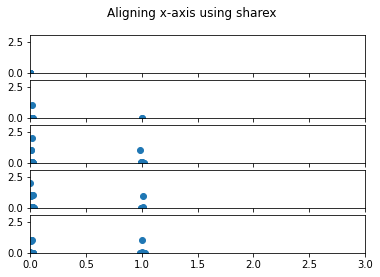

In [34]:
#모델 link function 고민
#cctv와 사고 건수 클러스터별 관계
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

crowded_clust = X_train_l.groupby(0).count().sort_values('lon').lon.iloc[-5:].index

fig, axs = plt.subplots(len(crowded_clust), sharex=True)
fig.suptitle('Aligning x-axis using sharex')

for i in range(len(crowded_clust)):
  ploting_x = X_train_l.loc[X_train_l.loc[:,0]==crowded_clust[i],"overspeed_cam_count100"]
  axs[i].scatter(rand_jitter(ploting_x), rand_jitter(Y_train.loc[ploting_x.index]))
  axs[i].set_xlim(( 0, 3))
  axs[i].set_ylim((0, 3))

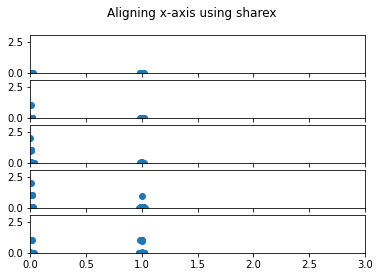

In [35]:
#배리어와 사고 건수 클러스터별 관계
crowded_clust = X_train_l.groupby(0).count().sort_values('lon').lon.iloc[-5:].index

fig, axs = plt.subplots(len(crowded_clust), sharex=True)
fig.suptitle('Aligning x-axis using sharex')

for i in range(len(crowded_clust)):
  ploting_x = X_train_l.loc[X_train_l.loc[:,0]==crowded_clust[i],"barrier_nearby_count25"]
  axs[i].scatter(rand_jitter(ploting_x), rand_jitter(Y_train.loc[ploting_x.index]))
  axs[i].set_xlim(( 0, 3))
  axs[i].set_ylim((0, 3))

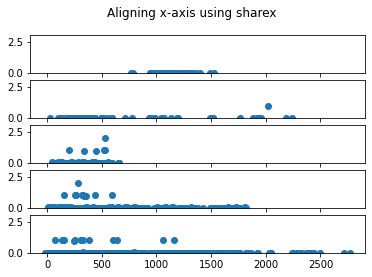

In [36]:
#범프와 사고 건수 클러스터별 관계
crowded_clust = X_train_l.groupby(0).count().sort_values('lon').lon.iloc[-5:].index

fig, axs = plt.subplots(len(crowded_clust), sharex=True)
fig.suptitle('Aligning x-axis using sharex')

for i in range(len(crowded_clust)):
  ploting_x = X_train_l.loc[X_train_l.loc[:,0]==crowded_clust[i],"shortest_bump_dist"]
  axs[i].scatter(rand_jitter(ploting_x), rand_jitter(Y_train.loc[ploting_x.index]))
  # axs[i].set_xlim(( 0, 3))
  axs[i].set_ylim((0, 3))

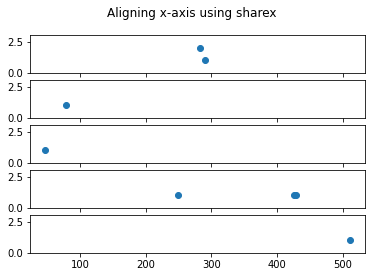

In [37]:
#사고 많이난 지점에서 영향???
#범프를 세울지 말지


#범프와 사고 건수 클러스터별 관계
high_acc_clust = df6_ss.index[:5]

fig, axs = plt.subplots(len(high_acc_clust), sharex=True)
fig.suptitle('Aligning x-axis using sharex')

for i in range(len(high_acc_clust)):
  ploting_x = X_train_l.loc[X_train_l.loc[:,0]==high_acc_clust[i],"shortest_bump_dist"]
  axs[i].scatter(rand_jitter(ploting_x), rand_jitter(Y_train.loc[ploting_x.index]))
  # axs[i].set_xlim(( 0, 3))
  axs[i].set_ylim((0, 3))

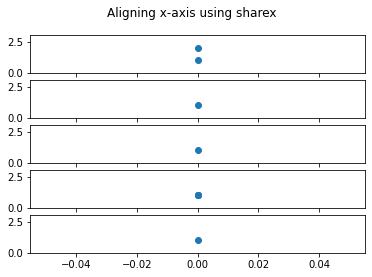

In [38]:
#배리어와 사고 건수 클러스터별 관계
high_acc_clust = df6_ss.index[:5]

fig, axs = plt.subplots(len(high_acc_clust), sharex=True)
fig.suptitle('Aligning x-axis using sharex')

for i in range(len(high_acc_clust)):
  ploting_x = X_train_l.loc[X_train_l.loc[:,0]==high_acc_clust[i],"barrier_nearby_count25"]
  axs[i].scatter(rand_jitter(ploting_x), rand_jitter(Y_train.loc[ploting_x.index]))
  # axs[i].set_xlim(( 0, 3))
  axs[i].set_ylim((0, 3))

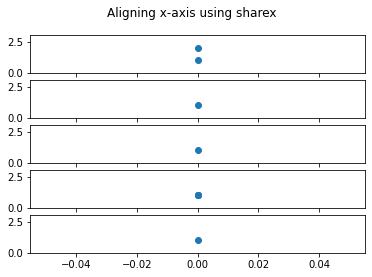

In [39]:
#과속방지 카메라 설치 안돼 있네... 그러면 당연히 회귀했을때 계수 안뜨겠지
#rank가 딸려버려서 inverse랑 beta 못구함
high_acc_clust = df6_ss.index[:5]

fig, axs = plt.subplots(len(high_acc_clust), sharex=True)
fig.suptitle('Aligning x-axis using sharex')

for i in range(len(high_acc_clust)):
  ploting_x = X_train_l.loc[X_train_l.loc[:,0]==high_acc_clust[i],"overspeed_cam_count100"]
  axs[i].scatter(rand_jitter(ploting_x), rand_jitter(Y_train.loc[ploting_x.index]))
  # axs[i].set_xlim(( 0, 3))
  axs[i].set_ylim((0, 3))

In [40]:
#2nd cluster는 그냥 크게 나누는게 좋을듯

# #2nd class cluster
# #dbscan 통계량 분리
# #이건 직관적이여서 굳이 dbscan으로 분리 안해도 될듯
# #직접 보고 정해도 될듯

# df6_s_sc = StandardScaler().fit_transform(df6_s.loc[:,['accident_over_rows']])
# plt.plot(range(len(df6_s_sc)),df6_s_sc)
# #0.28, 2

# db = DBSCAN(eps=0.28, min_samples=2).fit(df6_s_sc)
# labels = db.labels_

# df3 = pd.concat([df6_s,pd.DataFrame(db.labels_,index=df6_s.index)],axis=1)
# # df3.loc[df3.loc[:,0]==0]
# # -1 0 1 2 3 총3개 나옴

In [41]:
#2nd cluster dbscan으로 했을때

# #예외처리

# #cluster 중앙값 구하는 
# def centre(cluster_id):
#   currentMinimum = 99999
#   datas = df1.loc[labels_s == cluster_id,cols]
#   datas_s = StandardScaler().fit_transform(datas)

#   for point_idx in range(len(datas_s)):
#       distance_sum = 0
#       for second_point_idx in range(len(datas_s)):
#           if point_idx == second_point_idx : continue
#           distance_sum += np.linalg.norm(datas_s[point_idx] - datas_s[second_point_idx])
#       # print('>>>>>', point_idx, distance_sum) 

#       if distance_sum < currentMinimum :
#           currentMinimum = distance_sum 
#           centre_point = datas_s[point_idx]
#   return centre_point

# #클러스터 끼리 중앙값중 가장 짧은 클러스터 구하기
# #근데 ㅋㅋㅋ cluster 전부다 test set 들어가면 매치 못함 ㅋㅋㅋ
# def closest(cluster_id):
#   currentMinimum = 99999
#   clusters = list(set(labels_s))
#   centre_point = centre(cluster_id)

#   distance = 0
#   for second_point_idx in range(len(clusters)):
#     if cluster_id == clusters[second_point_idx] : continue
#     distance = np.linalg.norm(centre_point - centre(clusters[second_point_idx]))
#     # print('>>>>>', second_point_idx, distance) 

#     if distance < currentMinimum :
#       currentMinimum = distance 
#       closest_clust = clusters[second_point_idx]

#   return closest_clust

# #second closest
# def closest2(cluster_id):
#   closest_ = closest(cluster_id)
#   currentMinimum = 99999
#   clusters = list(set(labels_s))
#   centre_point = centre(cluster_id)

#   distance = 0
#   for second_point_idx in range(len(clusters)):
#     if (cluster_id == clusters[second_point_idx]) or (closest_ == clusters[second_point_idx]): continue
#     distance = np.linalg.norm(centre_point - centre(clusters[second_point_idx]))
#     # print('>>>>>', second_point_idx, distance) 

#     if distance < currentMinimum :
#       currentMinimum = distance 
#       closest_clust = clusters[second_point_idx]

#   return closest_clust

    


# dic_1st_to_2nd = dict(zip(df3.index,df3.loc[:,'second_class']))


# #dbscan 최근접 cluster로 보내주는 함수 만들어서 쓰는게 좋을듯
# #다 0으로 몰아넣지 말고

# print(list(set(labels_s) - set(dic_1st_to_2nd.keys())))
# #test set에서 안나오는 1st clusster 값들 있음
# #일일이 보는게 좋긴함
# for i in list(set(labels_s) - set(dic_1st_to_2nd.keys())):
#   closest_clust = closest(i)
#   if closest_clust in dic_1st_to_2nd.keys():
#     dic_1st_to_2nd[i] = dic_1st_to_2nd[closest_clust]
#   else:
#     dic_1st_to_2nd[i] = dic_1st_to_2nd[closest2(i)]


In [42]:
#2nd cluster dbscan으로 했을때

# #안전 시설물까지 넣어서 회귀 모형 train 하자

# #train 에 label 붙이고
# #learn col 붙여
# X_train_l = pd.concat([df1,pd.DataFrame(labels_s)],axis=1).loc[X_train.index,learn_cols+[0]]
# X_test_l = pd.concat([df1,pd.DataFrame(labels_s)],axis=1).loc[X_test.index,learn_cols+[0]]

# #붙인거 1st class 에 따라 나눠
# X_train_l.loc[X_train_l.loc[:,0].apply(lambda x: dic_1st_to_2nd[x]) == -1]
# X_train_l.loc[X_train_l.loc[:,0].apply(lambda x: dic_1st_to_2nd[x]) == 0]
# X_train_l.loc[X_train_l.loc[:,0].apply(lambda x: dic_1st_to_2nd[x]) == 1]
# X_train_l.loc[X_train_l.loc[:,0].apply(lambda x: dic_1st_to_2nd[x]) == 2]
# X_train_l.loc[X_train_l.loc[:,0].apply(lambda x: dic_1st_to_2nd[x]) == 3]


# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.preprocessing import MinMaxScaler

# #원래 -1 0 1 2 3 다 돌아가야하는데 test set에 안뽑히는것도 나옴 <- 수작업으로 걸러줘야함
# squared_error = 0
# test_predict_set = []
# for i in [-1,0,1,2,3]:
#   # 2nd clust == 0 인거 해보자
#   X_train0 = X_train_l.loc[X_train_l.loc[:,0].apply(lambda x: dic_1st_to_2nd[x]) == i]
#   Y_train0 = df1.loc[X_train0.index, ["accident_count12.5"]]

#   X_test0 = X_test_l.loc[X_test_l.loc[:,0].apply(lambda x: dic_1st_to_2nd[x]) == i]
#   Y_test0 = df1.loc[X_test0.index, ["accident_count12.5"]]

#   # minmax scaler

#   X_train0 = MinMaxScaler().fit_transform(X_train0)
#   X_test0 = MinMaxScaler().fit_transform(X_test0)
#   Y_train0 = MinMaxScaler().fit_transform(Y_train0)
#   Y_test0 = MinMaxScaler().fit_transform(Y_test0)


#   #train만으로 cv 돌려서 hyper param 조율
#   rf = RandomForestRegressor(bootstrap=True, max_depth=90,max_features='sqrt',min_samples_leaf=4, min_samples_split= 2, n_estimators=180, random_state=1)
#   rf.fit(X_train0, Y_train0)
#   # print(rf.predict(X_test0))
#   print(i,'번째 score',rf.score(X_train0,Y_train0))
#   squared_error += (metrics.mean_squared_error(Y_test0, rf.predict(X_test0)))*len(Y_test0)
#   print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test0, rf.predict(X_test0))))
#   print('Squared Error:', (metrics.mean_squared_error(Y_test0, rf.predict(X_test0)))*len(Y_test0))
#   print(squared_error, len(Y_test0))
#   print(" ")
#   test_predict_set.append([Y_test0,rf.predict(X_test0)])
# print('Total Root Mean Squared Error:', np.sqrt(squared_error/len(Y_test)))